In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats as st
import seaborn as sns
import time
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
# Function to generate the feature matrix using feature mapping
def phi_x(omega_phi,b_phi,x_phi,M_phi):
    return (np.sqrt(2) / np.sqrt(M_phi)) * np.cos(np.dot(omega_phi, x_phi.T) + b_phi[:, np.newaxis])

# Function representing the true underlying relationship
def f_true(x_f):
    return 0.8 * np.sin(np.pi*(0.7*x_f[2]+0.2*x_f[1]+0.1*x_f[0]))

def generate_time_series(n_ge):
    x_ge = np.zeros([n_ge])
    for t in range(3, n_ge):
        x_ge[t] = f_true(x_ge[t-3:t]) + np.random.uniform(-0.6, 0.6)
    return x_ge

def regularized_regression(S_M_re, y_re, lam_re,M_re):
    n_re = y_re.shape[0]
    theta_re = np.linalg.solve(np.dot(S_M_re, S_M_re.T) + lam_re * n_re * np.identity(M_re), np.dot(S_M_re, y_re))
    return theta_re


def cross_validate_lam(X, y,omega,b,M, lam_values, num_folds=5, random_state=None):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    mse_values = []

    for lam in lam_values:
        fold_mse = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            S_M_train = phi_x(omega,b,X_train,M)
            if S_M_train.shape[1]==1:
                S_M_train.reshape(S_M_train.shape[0],)
            
            theta = regularized_regression(S_M_train, y_train, lam,M)

            S_M_val = phi_x(omega,b,X_val,M)
            pred = np.dot(S_M_val.T, theta)

            fold_mse.append(mean_squared_error(f_true(X_val.T), pred))

        mse_values.append(np.mean(fold_mse))

    optimal_lam = lam_values[np.argmin(mse_values)]
    return optimal_lam

# Define a function to encapsulate the loop
def run_optimization_loop(n_points_values, ratio, num_iterations, train_percentage=0.6):
    mse_results = {}
    time_results = {}

    for n_points in n_points_values:
        mse_optimal_list = []
        time_list = []
        train_size = int(train_percentage * n_points)
        M = int(ratio*train_size)
        print(M)

        for _ in range(num_iterations):
            # Generate time series data
            time_series = generate_time_series(n_points)
            
            # Use only the first train_percentage of data for training
            x_train = np.array([time_series[i:i+3] for i in range(train_size-3)])
            y_train = time_series[3:train_size]
            
            # The rest is used for testing
            x_test = np.array([time_series[i+train_size-2:i+train_size+1] for i in range(len(time_series)-train_size)])
           

            # Generate random parameters
            mean = np.zeros(3)  # Mean vector of length 3 (3 dimensions)
            covariance = 2 * np.eye(3)  # Covariance matrix with diagonal elements equal to sqrt(2)

            # Generate samples from multivariate normal distribution
            omega_1 = np.random.multivariate_normal(mean, covariance, M)
            b_1 = np.random.uniform(0, 2 * np.pi, M)

            lam_values = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
            start_time = time.time()
            optimal_lam_1= cross_validate_lam(X=x_train, y=y_train,omega=omega_1,b=b_1,M=M, lam_values=lam_values, num_folds=3)

            # Now use the optimal lambda for the final model
            S_M = phi_x(omega_1,b_1,x_train,M)
            theta_optimal = regularized_regression(S_M, y_train, optimal_lam_1,M)

            # Make predictions using the trained model with optimal lambda on the test data
            pred_optimal = np.dot(phi_x(omega_1,b_1,x_test,M).T, theta_optimal)

            # Calculate mean squared error on the test data
            mse_optimal = mean_squared_error(f_true(x_test.T), pred_optimal)

            end_time = time.time()

            # Append results to lists
            mse_optimal_list.append(mse_optimal)
            time_list.append(end_time - start_time)

        mse_results[n_points] = mse_optimal_list
        time_results[n_points] = time_list

    return mse_results, time_results

In [ ]:
mse_results = {}
time_results = {}

for n_points in n_points_values:
    mse_optimal_list = []
    time_list = []
    train_size = 1000
    M = 100
    print(M)

    for _ in range(num_iterations):
            # Generate time series data
        time_series = generate_time_series(n_points)
            
            # Use only the first train_percentage of data for training
            
            
        x_train = np.array([time_series[i:i+3] for i in range(train_size-3)])
        y_train = time_series[3:train_size]
            
            # The rest is used for testing
        x_test = np.array([time_series[i+train_size-2:i+train_size+1] for i in range(len(time_series)-train_size)])

            # Generate random parameters
        mean = np.zeros(3)  # Mean vector of length 3 (3 dimensions)
        covariance = 2 * np.eye(3)  # Covariance matrix with diagonal elements equal to sqrt(2)

            # Generate samples from multivariate normal distribution
        omega_1 = np.random.multivariate_normal(mean, covariance, M)
        b_1 = np.random.uniform(0, 2 * np.pi, M)

        lam_values = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
        start_time = time.time()
        optimal_lam_1= cross_validate_lam(X=x_train, y=y_train,omega=omega_1,b=b_1,M=M, lam_values=lam_values, num_folds=3)

            # Now use the optimal lambda for the final model
        S_M = phi_x(omega_1,b_1,x_train,M)
        theta_optimal = regularized_regression(S_M, y_train, optimal_lam_1,M)

            # Make predictions using the trained model with optimal lambda on the test data
        pred_optimal = np.dot(phi_x(omega_1,b_1,x_test,M).T, theta_optimal)

            # Calculate mean squared error on the test data
        mse_optimal = mean_squared_error(f_true(x_test.T), pred_optimal)

        end_time = time.time()

            # Append results to lists
        mse_optimal_list.append(mse_optimal)
        time_list.append(end_time - start_time)

    mse_results[n_points] = mse_optimal_list
    time_results[n_points] = time_list

In [3]:
def run_optimization_loop_vary_ra(n, ratio_values, num_iterations, train_percentage=0.6):
    mse_results = {}
    time_results = {}

    for ratio in ratio_values:
        mse_optimal_list = []
        time_list = []
        
        train_size = int(train_percentage * n)
        M = int(ratio * train_size)
        print(M)

        for _ in range(num_iterations):
            # Generate time series data
            time_series = generate_time_series(n)
            
            # Use only the first train_percentage of data for training
            x_train = np.array([time_series[i:i+3] for i in range(train_size-3)])
            y_train = time_series[3:train_size]
            
            # The rest is used for testing
            x_test = np.array([time_series[i+train_size-2:i+train_size+1] for i in range(len(time_series)-train_size)])

            # Generate random parameters
            mean = np.zeros(3)  # Mean vector of length 3 (3 dimensions)
            covariance = 2 * np.eye(3)  # Covariance matrix with diagonal elements equal to sqrt(2)

            # Generate samples from multivariate normal distribution
            omega_1 = np.random.multivariate_normal(mean, covariance, M)
            b_1 = np.random.uniform(0, 2 * np.pi, M)

            lam_values = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
            start_time = time.time()
            optimal_lam_1 = cross_validate_lam(X=x_train, y=y_train, omega=omega_1, b=b_1, M=M, lam_values=lam_values, num_folds=3)

            # Now use the optimal lambda for the final model
            S_M = phi_x(omega_1, b_1, x_train, M)
            theta_optimal = regularized_regression(S_M, y_train, optimal_lam_1, M)

            # Make predictions using the trained model with optimal lambda on the test data
            pred_optimal = np.dot(phi_x(omega_1, b_1, x_test, M).T, theta_optimal)

            # Calculate mean squared error on the test data
            mse_optimal = mean_squared_error(f_true(x_test.T), pred_optimal)

            end_time = time.time()

            # Append results to lists
            mse_optimal_list.append(mse_optimal)
            time_list.append(end_time - start_time)

        mse_results[ratio] = mse_optimal_list
        time_results[ratio] = time_list

    return mse_results,time_results

# Vary n

In [4]:
# Define values for n_points and run the loop
n_points_values =[1500,3000,4500,7500,11250,15000]

num_iterations = 100

ratio= 0.001 #0.005,0.01,0.05,0.1
mse_results_n_points_1, time_results_n_points_1= run_optimization_loop(n_points_values, ratio, num_iterations, train_percentage=2/3)

1
2
3
5
7
10


In [5]:
ratio= 0.005
mse_results_n_points_2, time_results_n_points_2 = run_optimization_loop(n_points_values, ratio, num_iterations, train_percentage=2/3)

5
10
15
25
37
50


In [6]:
ratio= 0.01
mse_results_n_points_3, time_results_n_points_3= run_optimization_loop(n_points_values, ratio, num_iterations, train_percentage=2/3)

10
20
30
50
75
100


In [7]:
ratio= 0.05
mse_results_n_points_4, time_results_n_points_4= run_optimization_loop(n_points_values, ratio, num_iterations,train_percentage=2/3)

50
100
150
250
375
500


In [8]:
ratio= 0.1
mse_results_n_points_5, time_results_n_points_5= run_optimization_loop(n_points_values, ratio, num_iterations, train_percentage=2/3)

100
200
300
500
750
1000


In [9]:
pd.DataFrame(time_results_n_points_1).to_excel('time_results_n_points_1_multi.xlsx')
pd.DataFrame(time_results_n_points_2).to_excel('time_results_n_points_2_multi.xlsx')
pd.DataFrame(time_results_n_points_3).to_excel('time_results_n_points_3_multi.xlsx')
pd.DataFrame(time_results_n_points_4).to_excel('time_results_n_points_4_multi.xlsx')
pd.DataFrame(time_results_n_points_5).to_excel('time_results_n_points_5_multi.xlsx')



pd.DataFrame(mse_results_n_points_1).to_excel('mse_results_n_points_1_multi.xlsx')
pd.DataFrame(mse_results_n_points_2).to_excel('mse_results_n_points_2_multi.xlsx')
pd.DataFrame(mse_results_n_points_3).to_excel('mse_results_n_points_3_multi.xlsx')
pd.DataFrame(mse_results_n_points_4).to_excel('mse_results_n_points_4_multi.xlsx')
pd.DataFrame(mse_results_n_points_5).to_excel('mse_results_n_points_5_multi.xlsx')

In [25]:
time_1=np.array(pd.read_excel('time_results_n_points_1_multi.xlsx').iloc[:,1:])
time_2=np.array(pd.read_excel('time_results_n_points_2_multi.xlsx').iloc[:,1:])
time_3=np.array(pd.read_excel('time_results_n_points_3_multi.xlsx').iloc[:,1:])
time_4=np.array(pd.read_excel('time_results_n_points_4_multi.xlsx').iloc[:,1:])
time_5=np.array(pd.read_excel('time_results_n_points_5_multi.xlsx').iloc[:,1:])

In [26]:
mse_1=np.array(pd.read_excel('mse_results_n_points_1_multi.xlsx').iloc[:,1:])
mse_2=np.array(pd.read_excel('mse_results_n_points_2_multi.xlsx').iloc[:,1:])
mse_3=np.array(pd.read_excel('mse_results_n_points_3_multi.xlsx').iloc[:,1:])
mse_4=np.array(pd.read_excel('mse_results_n_points_4_multi.xlsx').iloc[:,1:])
mse_5=np.array(pd.read_excel('mse_results_n_points_5_multi.xlsx').iloc[:,1:])

In [10]:
time_1= np.zeros([num_iterations,6])
time_1[:,0]=time_results_n_points_1[n_points_values[0]]
time_1[:,1]=time_results_n_points_1[n_points_values[1]]
time_1[:,2]=time_results_n_points_1[n_points_values[2]]
time_1[:,3]=time_results_n_points_1[n_points_values[3]]
time_1[:,4]=time_results_n_points_1[n_points_values[4]]
time_1[:,5]=time_results_n_points_1[n_points_values[5]]


time_2= np.zeros([num_iterations,6])
time_2[:,0]=time_results_n_points_2[n_points_values[0]]
time_2[:,1]=time_results_n_points_2[n_points_values[1]]
time_2[:,2]=time_results_n_points_2[n_points_values[2]]
time_2[:,3]=time_results_n_points_2[n_points_values[3]]
time_2[:,4]=time_results_n_points_2[n_points_values[4]]
time_2[:,5]=time_results_n_points_2[n_points_values[5]]

time_3= np.zeros([num_iterations,6])
time_3[:,0]=time_results_n_points_3[n_points_values[0]]
time_3[:,1]=time_results_n_points_3[n_points_values[1]]
time_3[:,2]=time_results_n_points_3[n_points_values[2]]
time_3[:,3]=time_results_n_points_3[n_points_values[3]]
time_3[:,4]=time_results_n_points_3[n_points_values[4]]
time_3[:,5]=time_results_n_points_3[n_points_values[5]]


time_4= np.zeros([num_iterations,6])
time_4[:,0]=time_results_n_points_4[n_points_values[0]]
time_4[:,1]=time_results_n_points_4[n_points_values[1]]
time_4[:,2]=time_results_n_points_4[n_points_values[2]]
time_4[:,3]=time_results_n_points_4[n_points_values[3]]
time_4[:,4]=time_results_n_points_4[n_points_values[4]]
time_4[:,5]=time_results_n_points_4[n_points_values[5]]


time_5= np.zeros([num_iterations,6])
time_5[:,0]=time_results_n_points_5[n_points_values[0]]
time_5[:,1]=time_results_n_points_5[n_points_values[1]]
time_5[:,2]=time_results_n_points_5[n_points_values[2]]
time_5[:,3]=time_results_n_points_5[n_points_values[3]]
time_5[:,4]=time_results_n_points_5[n_points_values[4]]
time_5[:,5]=time_results_n_points_5[n_points_values[5]]

In [11]:
mse_1= np.zeros([num_iterations,6])
mse_1[:,0]=mse_results_n_points_1[n_points_values[0]]
mse_1[:,1]=mse_results_n_points_1[n_points_values[1]]
mse_1[:,2]=mse_results_n_points_1[n_points_values[2]]
mse_1[:,3]=mse_results_n_points_1[n_points_values[3]]
mse_1[:,4]=mse_results_n_points_1[n_points_values[4]]
mse_1[:,5]=mse_results_n_points_1[n_points_values[5]]


mse_2= np.zeros([num_iterations,6])
mse_2[:,0]=mse_results_n_points_2[n_points_values[0]]
mse_2[:,1]=mse_results_n_points_2[n_points_values[1]]
mse_2[:,2]=mse_results_n_points_2[n_points_values[2]]
mse_2[:,3]=mse_results_n_points_2[n_points_values[3]]
mse_2[:,4]=mse_results_n_points_2[n_points_values[4]]
mse_2[:,5]=mse_results_n_points_2[n_points_values[5]]

mse_3= np.zeros([num_iterations,6])
mse_3[:,0]=mse_results_n_points_3[n_points_values[0]]
mse_3[:,1]=mse_results_n_points_3[n_points_values[1]]
mse_3[:,2]=mse_results_n_points_3[n_points_values[2]]
mse_3[:,3]=mse_results_n_points_3[n_points_values[3]]
mse_3[:,4]=mse_results_n_points_3[n_points_values[4]]
mse_3[:,5]=mse_results_n_points_3[n_points_values[5]]


mse_4= np.zeros([num_iterations,6])
mse_4[:,0]=mse_results_n_points_4[n_points_values[0]]
mse_4[:,1]=mse_results_n_points_4[n_points_values[1]]
mse_4[:,2]=mse_results_n_points_4[n_points_values[2]]
mse_4[:,3]=mse_results_n_points_4[n_points_values[3]]
mse_4[:,4]=mse_results_n_points_4[n_points_values[4]]
mse_4[:,5]=mse_results_n_points_4[n_points_values[5]]


mse_5= np.zeros([num_iterations,6])
mse_5[:,0]=mse_results_n_points_5[n_points_values[0]]
mse_5[:,1]=mse_results_n_points_5[n_points_values[1]]
mse_5[:,2]=mse_results_n_points_5[n_points_values[2]]
mse_5[:,3]=mse_results_n_points_5[n_points_values[3]]
mse_5[:,4]=mse_results_n_points_5[n_points_values[4]]
mse_5[:,5]=mse_results_n_points_5[n_points_values[5]]

In [12]:
aa=[0.001,0.005,0.01,0.05,0.1]

In [27]:
# Create time_dict
times_dict = {
     aa[0]: time_1,
    aa[1]: time_2,
    aa[2]: time_3,
   aa[3]: time_4,
   aa[4]: time_5
}

In [28]:
# Create mse_dict
mse_dict = {
     aa[0]: np.sqrt(mse_1),
     aa[1]: np.sqrt(mse_2),
     aa[2]: np.sqrt(mse_3),
     aa[3]: np.sqrt(mse_4),
     aa[4]: np.sqrt(mse_5)
}

In [29]:
settings = [
     {'Ratio': aa[0], 'linestyle':  (0, (3, 1, 1, 1)), 'color': '#95b083'},
    {'Ratio': aa[1], 'linestyle': 'solid', 'color': 'dodgerblue'},
    {'Ratio': aa[2], 'linestyle': 'dotted', 'color': 'purple'},
    {'Ratio': aa[3], 'linestyle': 'dashdot', 'color': '#362102'},
    {'Ratio': aa[4], 'linestyle': 'dashed', 'color': '#FA740A'}
]

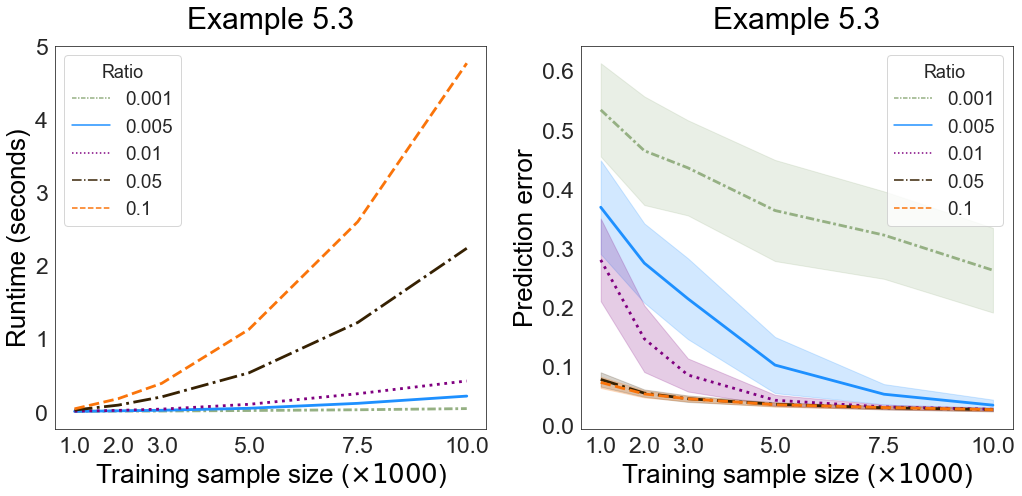

In [30]:
import matplotlib.pyplot as plt
n_list = [1, 2, 3, 5, 7.5, 10]
# Assuming you have necessary libraries imported

sns.set_style("white")

# Create a figure with subplots in a 2x2 grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5, 7.))
plt.subplots_adjust(wspace=5,  hspace=5)  # Adjusted wspace and hspace for better spacing

# Subplot 1 - Top left
for setting in settings:
    ratio = setting['Ratio']
    linestyle = setting['linestyle']
    color = setting['color']
    
    time_values = times_dict[ratio]
    mean_time = time_values.mean(axis=0)
    
    axes[0].plot(n_list, mean_time, linestyle=linestyle, color=color, label=f'{ratio}')

axes[0].set_xticks(n_list)
axes[0].tick_params(axis='both', labelsize=23)
axes[0].set_xlabel(r'Training sample size ($\times 1000$)', fontsize=26, color='k')
axes[0].set_ylabel('Runtime (seconds)', fontsize=26, color='k')
axes[0].legend(title='Ratio', loc='upper left', ncol=1, fontsize=19,title_fontsize=18)

for line in axes[0].lines:
    line.set_linewidth(2.8)

# Subplot 2 - Top right
for setting in settings:
    ratio = setting['Ratio']
    linestyle = setting['linestyle']
    color = setting['color']
    
    mse_values = mse_dict[ratio]
    mean_values = mse_values.mean(axis=0)
    std_values = mse_values.std(axis=0)
    
    axes[1].plot(n_list, mean_values, color=color, linestyle=linestyle, label=f'{ratio}')
    axes[1].fill_between(n_list, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

axes[1].set_xticks(n_list)
axes[1].tick_params(axis='both', labelsize=23)
axes[1].set_xlabel(r'Training sample size ($\times 1000$)', fontsize=26, color='k')
axes[1].set_ylabel('Prediction error', fontsize=26, color='k')
axes[1].legend(title='Ratio', loc='upper right', ncol=1, fontsize=19,title_fontsize=18)
for line in axes[1].lines:
    line.set_linewidth(2.8)
plt.subplots_adjust(wspace=5,  hspace=5)  # Adjusted wspace and hspace for better spacing



# Add individual titles to each subplot
axes[0].set_title("Example 5.3", fontsize=30, color='k',y=1.03)
axes[1].set_title("Example 5.3", fontsize=30, color='k',y=1.03)


# Adjust layout for better spacing
plt.tight_layout()

# Display the combined figure
plt.savefig("Random_features_vs_n_multi.png", bbox_inches='tight', dpi=200)

# Vary M

In [17]:
# Define values for n_points and run the loop
n = 6000
num_iterations = 100
ratio_values =np.exp(np.linspace(-7,-1,15))
mse_results_n_points_1, time_results_n_points_1= run_optimization_loop_vary_ra(n, ratio_values, num_iterations, train_percentage=2/3)

3
5
8
13
20
31
47
73
112
172
265
406
624
958
1471


In [18]:
pd.DataFrame(mse_results_n_points_1).to_excel('mse_results_n_points_vary_m_multi.xlsx')
pd.DataFrame(time_results_n_points_1).to_excel('time_results_n_points_vary_m_multi.xlsx')

In [19]:
mse= np.zeros([num_iterations,15])
for i in range(15):
    mse[:,i]=mse_results_n_points_1[ratio_values[i]]
mse=np.sqrt(mse) 
times= np.zeros([num_iterations,15])
for i in range(15):
    times[:,i]=time_results_n_points_1[ratio_values[i]]

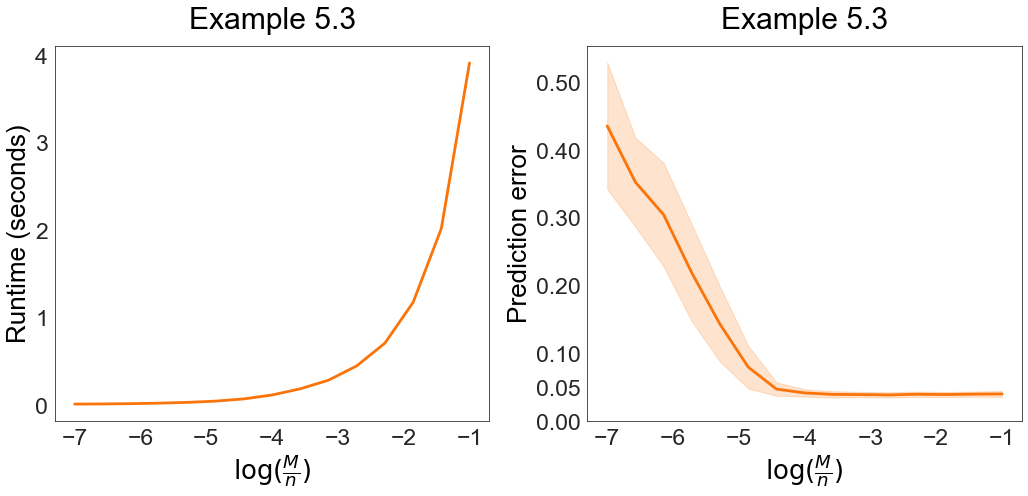

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# Create a figure with subplots in a 2x2 grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5, 7))
plt.subplots_adjust(wspace=5,  hspace=5)  # Adjusted wspace and hspace for better spacing
# Plot the first figure on the top-left subplot
linestyle = 'solid'
color = '#FA740A'
mean_time = times.mean(axis=0)
axes[0].plot(np.linspace(-7, -1, 15), mean_time, linestyle=linestyle, color=color)
axes[0].set_xticks(np.linspace(-7, -1, 7))
axes[0].tick_params(axis='both', labelsize=23)
axes[0].set_xlabel(r'$\log(\frac{M}{n})$', fontsize=26, color='k')
axes[0].set_ylabel('Runtime (seconds)', fontsize=26, color='k')
for line in axes[0].lines:
    line.set_linewidth(2.8)

# Plot the second figure on the top-right subplot
mean_values = mse.mean(axis=0)
std_values = mse.std(axis=0)
axes[1].plot(np.linspace(-7, -1, 15), mean_values, color=color, linestyle=linestyle)
axes[1].fill_between(np.linspace(-7, -1, 15), mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)
axes[1].set_xticks(np.linspace(-7, -1, 7))
axes[1].set_yticks(np.array([0.00,0.05,0.10,0.20,0.30,0.4,0.5]))
axes[1].tick_params(axis='both', labelsize=23)
axes[1].set_xlabel(r'$\log(\frac{M}{n})$', fontsize=26, color='k')
axes[1].set_ylabel('Prediction error', fontsize=26, color='k')
for line in axes[1].lines:
    line.set_linewidth(2.8)



# Add individual titles to each subplot
axes[0].set_title("Example 5.3", fontsize=30, color='k',y=1.03)
axes[1].set_title("Example 5.3", fontsize=30, color='k',y=1.03)

plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("Random_features_vs_m_multi.png", bbox_inches='tight', dpi=200)

# Display the plot
plt.show()